In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Sep  3 12:15:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install transformers

In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch.nn.functional as F
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import sklearn.utils
import time
import re


In [6]:
# Retrive the data from stored dataset
dataDir = "/content/drive/MyDrive/WoS/data"
tsvData = os.path.join(dataDir,"WoSDataset_5736.tsv")

tsvData = np.loadtxt(tsvData, dtype=str, delimiter="\t")
print(np.shape(tsvData))

(5736, 4)


In [7]:
print(tsvData[0:15])

[['2' 'biochemistry'
  ' candidatus phytoplasma    16s rrna biosecurity taxonomy biodiversity vector seed transmission host range       '
  'phytoplasmas are insectvectored bacteria that cause disease in a wide range of plant species the increasing availability of molecular dna analyses expertise and additional methods in recent years has led to a proliferation of discoveries of phytoplasmaplant host associations and in the numbers of taxonomic groupings for phytoplasmas the widespread use of common names based on the diseases with which they are associated as well as separate phenetic and taxonomic systems for classifying phytoplasmas based on variation at the 16s rrnaencoding gene complicates interpretation of the literature we explore this issue and related trends through a focus on australian pathosystems providing the first comprehensive compilation of information for this continent covering the phytoplasmas host plants vectors and diseases of the 33 16sr groups reported internati

In [8]:
allLabels = tsvData[:,0]
domains = tsvData[:,1]
keywords = tsvData[:,2]
abstracts = tsvData[:,3]

In [9]:
labels = np.unique(domains, return_counts=True)[0]
labelCounts=  np.unique(domains, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['ECE' 'Psychology' 'biochemistry']
Label counts  [1292 1597 2847]


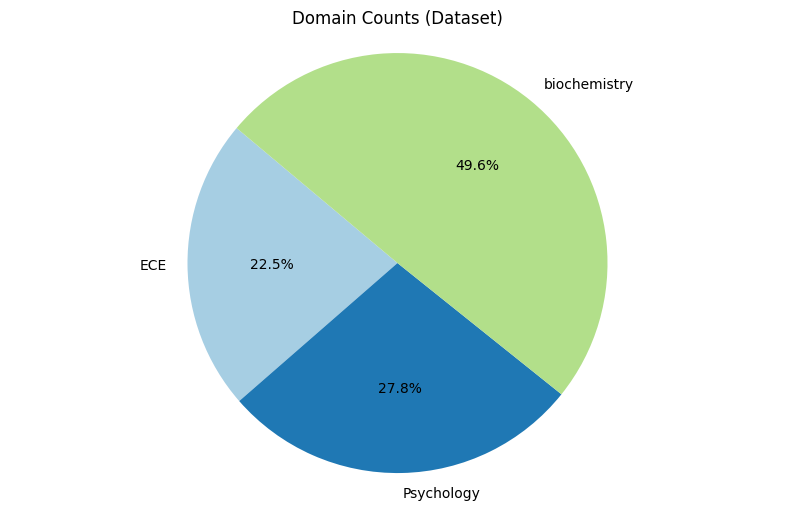

The domain ECE has 1292 records in the dataset.
The domain Psychology has 1597 records in the dataset.
The domain biochemistry has 2847 records in the dataset.


In [10]:
# Visualize domain counts in dataset
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the dataset.")

In [11]:
# Shuffle data
dataShuffled = sklearn.utils.shuffle(tsvData)

abstractsShuffled = dataShuffled[:,3]
keywordsShuffled = dataShuffled[:,2]
domainsShuffled = dataShuffled[:,1]
allLabelsShuffled = dataShuffled[:,0]

print("Number of abstracts: ", len(abstractsShuffled))
print("Shape of abstracts: ", np.shape(abstractsShuffled))
print(abstractsShuffled[0:2])

print("Number of keywords: ", len(keywordsShuffled))
print("Shape of keywords: ", np.shape(keywordsShuffled))
print(abstractsShuffled[0:2])

print("Number of domains: ", len(domainsShuffled))
print("Shape of domains: ", np.shape(domainsShuffled))
print(domainsShuffled[0:2])

print("Number of labels: ", len(allLabelsShuffled))
print("Shape of labels: ", np.shape(allLabelsShuffled))
print(allLabelsShuffled[0:2])


# Convert labels to integer
allLabelsDigitShuffled = allLabelsShuffled.astype(int)

print(abstractsShuffled[0:10])
print(keywordsShuffled[0:10])
print(domainsShuffled[0:10])
print(allLabelsShuffled[0:10])
print(allLabelsDigitShuffled[0:10])

Number of abstracts:  5736
Shape of abstracts:  (5736,)
['let ohm subset of r2 be an open domain with fractal boundary partial derivative ohm we define a proper convex and lower semicontinuous functional on the space x2ohmpartial derivative ohm  l2ohm dx x l2partial derivative ohm d mu and we characterize its subdifferential which gives rise to nonlocal venttsel boundary conditions then we consider the associated nonlinear semigroup tp generated by the opposite of the subdifferential and we prove that the corresponding abstract cauchy problem is uniquely solvable we prove that the unique strong solution solves a quasilinear parabolic venttsel problem with a nonlocal term on the boundary partial derivative ohm of ohm moreover we study the properties of the nonlinear semigroup tp and we prove that it is orderpreserving markovian and ultracontractive at the end we turn our attention to the elliptic venttsel problem and we show existence uniqueness and global boundedness of weak solutions 

In [12]:
# Split dataset into training and testing (80/20 split)
train_data, test_data = train_test_split(dataShuffled, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))

# Further split training data into training and validation (80/20 split of training set)
_, val_data = train_test_split(test_data, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))
# Load BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

(4588, 4)
(1148, 4)
(4588, 4)
(1148, 4)
(230, 4)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [13]:
abstractsTrain = train_data[:,3]
keywordsTrain = train_data[:,2]
domainsTrain = train_data[:,1]
allLabelsTrain = train_data[:,0]

print("Number of abstracts: ",len(abstractsTrain))
print("Shape of abstracts: ",np.shape(abstractsTrain))
print("Number of keywords: ",len(keywordsTrain))
print("Shape of keywords: ",np.shape(keywordsTrain))
print("Number of domains: ",len(domainsTrain))
print("Shape of domains: ",np.shape(domainsTrain))
print("Number of labels: ",len(allLabelsTrain))
print("Shape of labels: ",np.shape(allLabelsTrain))

print(abstractsTrain[0:2])
print(keywordsTrain[0:2])
print(domainsTrain[0:2])
print(allLabelsTrain[0:2])

Number of abstracts:  4588
Shape of abstracts:  (4588,)
Number of keywords:  4588
Shape of keywords:  (4588,)
Number of domains:  4588
Shape of domains:  (4588,)
Number of labels:  4588
Shape of labels:  (4588,)
['mobile technologies are increasingly adopted by information intensive organizations such as public police corporations to support the tasks of its employees for information management and innovation however because police organizations are government organizations technology decisions are largely made by managers and politicians with budget being a key factor therefore whether the technologies adopted are suitable for police tasks and if they enhance performance is generally not assessed the aim of this research is to establish if mobile technologies support police tasks and if tablet pcs especially are suitable for specialist police tasks of the criminal investigators and sexual offence and child abuse units guided by an interpretive paradigm and the theory of task technolog

Labels  ['ECE' 'Psychology' 'biochemistry']
Label counts  [1022 1304 2262]


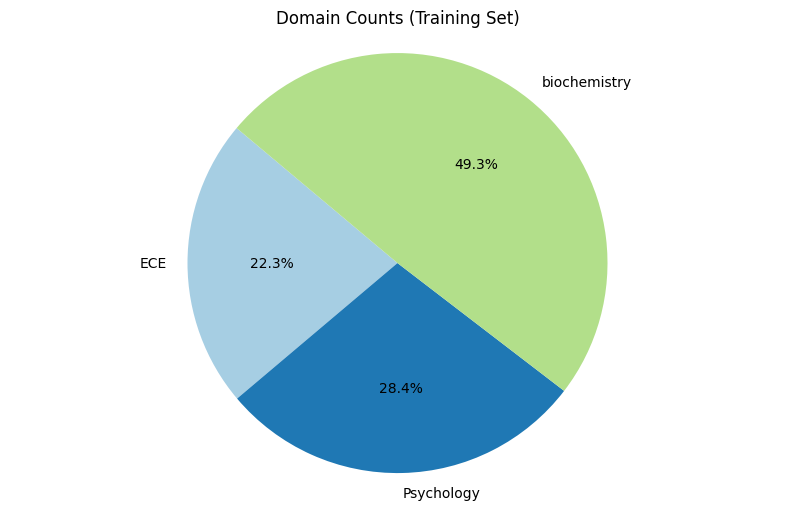

The domain ECE has 1022 records in the training set.
The domain Psychology has 1304 records in the training set.
The domain biochemistry has 2262 records in the training set.


In [14]:
labels = np.unique(domainsTrain, return_counts=True)[0]
labelCounts =  np.unique(domainsTrain, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsTrain)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Training Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the training set.")

In [15]:
abstractsTest = test_data[:,3]
keywordsTest = test_data[:,2]
domainsTest = test_data[:,1]
allLabelsTest = test_data[:,0]

print("Number of abstracts: ",len(abstractsTest))
print("Shape of abstracts: ",np.shape(abstractsTest))
print("Number of keywords: ",len(keywordsTest))
print("Shape of keywords: ",np.shape(keywordsTest))
print("Number of domains: ",len(domainsTest))
print("Shape of domains: ",np.shape(domainsTest))
print("Number of labels: ",len(allLabelsTest))
print("Shape of labels: ",np.shape(allLabelsTest))

# arr = np.array(domainsTest)
# cleaned_domains = np.char.strip(arr)
# print("Cleaned arr ", cleaned_domains)
# domainsLabelsTest = cleaned_domains
# print("Labels domains ", domainsLabelsTest)

print(abstractsTest[0:2])
print(keywordsTest[0:2])
print(domainsTest[0:2])
print(allLabelsTest[0:2])

Number of abstracts:  1148
Shape of abstracts:  (1148,)
Number of keywords:  1148
Shape of keywords:  (1148,)
Number of domains:  1148
Shape of domains:  (1148,)
Number of labels:  1148
Shape of labels:  (1148,)
['this article deals with the simulation of the power converter with voltagesource inverter and sinefilter the repetitive control system was designed the existing power converter has a control system which makes fourier transform of the output voltage to inject these harmonics with opposite phase the new proposed system based on repetitive controller which is much simpler and with smaller cpu load the higher harmonics elimination works perfect and the power converter produces output voltage with less than 5 thd under linear or nonlinear load this paper describes the improved control system structure and its implementation in matlab simulink environment the advantages of the repetitive algorithm facing fourier transform harmonic compensation are shown the performance of the new 

Labels  ['ECE' 'Psychology' 'biochemistry']
Label counts  [270 293 585]


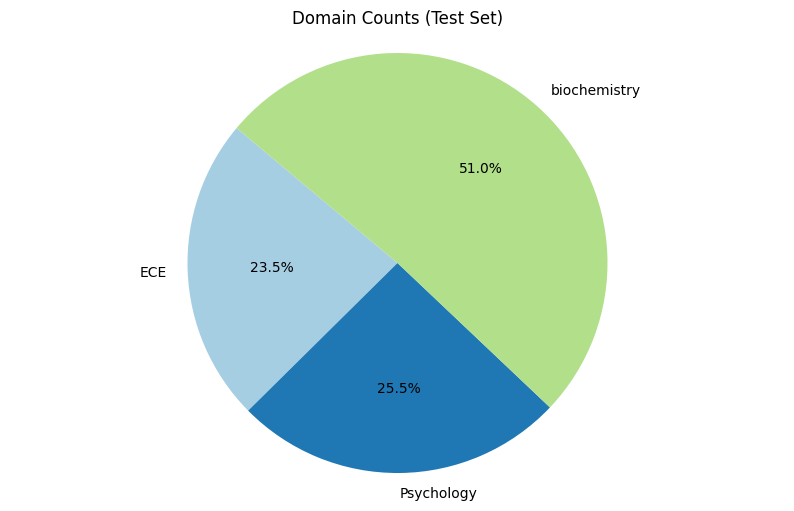

The domain ECE has 270 records in the test set.
The domain Psychology has 293 records in the test set.
The domain biochemistry has 585 records in the test set.


In [16]:
labels = np.unique(domainsTest, return_counts=True)[0]
labelCounts =  np.unique(domainsTest, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsTest)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Test Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the test set.")

In [17]:
abstractsVal = val_data[:,3]
keywordsVal = val_data[:,2]
domainsVal = val_data[:,1]
allLabelsVal = val_data[:,0]

print("Number of abstracts: ",len(abstractsVal))
print("Shape of abstracts: ",np.shape(abstractsVal))
print("Number of keywords: ",len(keywordsVal))
print("Shape of keywords: ",np.shape(keywordsVal))
print("Number of domains: ",len(domainsVal))
print("Shape of domains: ",np.shape(domainsVal))
print("Number of labels: ",len(allLabelsVal))
print("Shape of labels: ",np.shape(allLabelsVal))

print(abstractsVal[0:2])
print(keywordsVal[0:2])
print(domainsVal[0:2])
print(allLabelsVal[0:2])

Number of abstracts:  230
Shape of abstracts:  (230,)
Number of keywords:  230
Shape of keywords:  (230,)
Number of domains:  230
Shape of domains:  (230,)
Number of labels:  230
Shape of labels:  (230,)
['purpose of the review in this review we will discuss the basic fundamentals of how to perform molecular imaging to better understand the underlyingmechanisms contributing to cardiovascular disease report findings molecular imaging combines molecular biology with in vivo imaging molecular probes are used to target discrete biological processes such as cell death inflammation and angiogenesis these probes emit signals that are detected by traditional imaging systems because the same disease processes can manifest in individuals in different ways molecular imaging may emerge as an important strategy for delivering precision medicine summary molecular imaging is a powerful tool that may help physicians provide more personalized care in the near future'
 'the aim of this paper is to propo

Labels  ['ECE' 'Psychology' 'biochemistry']
Label counts  [ 60  53 117]


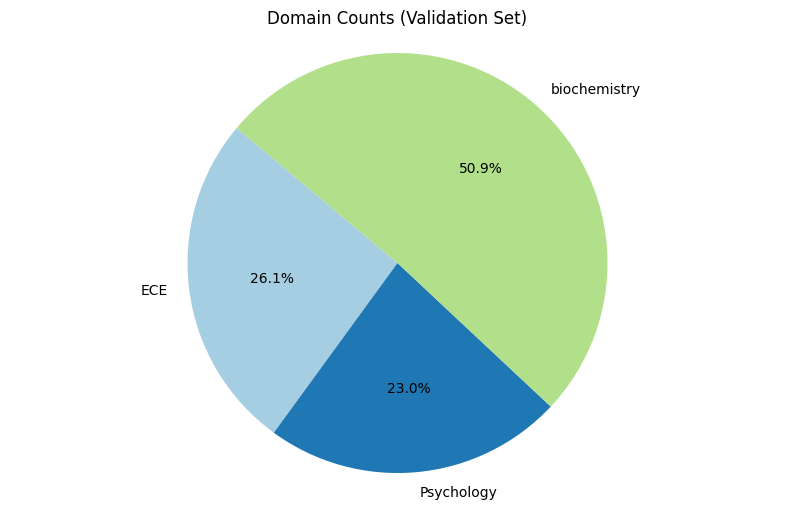

The domain ECE has 60 records in the vaidation set.
The domain Psychology has 53 records in the vaidation set.
The domain biochemistry has 117 records in the vaidation set.


In [18]:
labels = np.unique(domainsVal, return_counts=True)[0]
labelCounts =  np.unique(domainsVal, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsVal)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Validation Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the vaidation set.")

In [19]:
# Function to tokenize and encode the dataset
def encode_data(data, tokenizer, max_length=128):
    # print(len(data[:,2]))
    inputs = tokenizer(
        data[:,3].tolist(), # abstract
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )
    # print(len(dataShuffled[:, 0]))
    labels = torch.tensor(data[:, 0].astype(int))
    print("Label length ", len(labels))
    return TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

In [20]:
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))


(4588, 4)
(1148, 4)
(230, 4)


In [21]:
# Encode training, validation, and testing data
train_dataset = encode_data(train_data, tokenizer)
val_dataset = encode_data(val_data, tokenizer)
test_dataset = encode_data(test_data, tokenizer)



# Data loaders
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=32)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)

Label length  4588
Label length  230
Label length  1148


In [22]:
print(np.unique(train_data[:,0]))

['0' '1' '2']


In [23]:
# Load BERT model
print(len(np.unique(train_data[:,0])))
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(np.unique(train_data[:,0])))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

3


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [24]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [25]:
# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 20
num_warmup_steps = 1e-4
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
def calculate_metrics(valType, predictions, true_labels):
    # Confusion matrix
    if(valType == 'test'):
        cm = confusion_matrix(true_labels, predictions)
        print("Confusion Matrix:\n", cm)

        # Classification report (includes precision, recall, F1 score)
        report = classification_report(true_labels, predictions, target_names=[str(i) for i in range(len(np.unique(true_labels)))])
        print("\nClassification Report:\n", report)

        # Calculate different types of F1 scores, precision, and recall
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')

        print(f"Macro F1 Score: {f1_macro}")
        print(f"Micro F1 Score: {f1_micro}")
        print(f"Weighted F1 Score: {f1_weighted}")

        print(f"Macro Precision: {precision_macro}")
        print(f"Micro Precision: {precision_micro}")
        print(f"Weighted Precision: {precision_weighted}")

        print(f"Macro Recall: {recall_macro}")
        print(f"Micro Recall: {recall_micro}")
        print(f"Weighted Recall: {recall_weighted}")

    elif(valType == 'val'):
        cm = confusion_matrix(true_labels, predictions)
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')
        # print('Val Micro F1:', f1_micro)
        return f1_micro

In [27]:
epochs = 20
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    start_time = time.time()

    # Training
    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch


        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=input_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation
    model.eval()
    predictions = []
    true_labels = []

    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=input_mask)
            logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        batch_predictions = np.argmax(logits, axis=1)
        predictions.extend(batch_predictions)
        true_labels.extend(label_ids)

    val_micro_f1 = calculate_metrics('val', predictions, true_labels)
    elapsed_time = time.time() - start_time

    # Print epoch summary
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"  Train Loss: {avg_train_loss}")
    print(f"  Val Micro F1: {val_micro_f1}")
    print(f"  Time: {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

Epoch 1/20: 100%|██████████| 144/144 [01:33<00:00,  1.54batch/s]


Epoch 1/20
  Train Loss: 0.3239739878206617
  Val Micro F1: 0.9521739130434783
  Time: 1m 35s


Epoch 2/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 2/20
  Train Loss: 0.12295201090293834
  Val Micro F1: 0.9652173913043478
  Time: 1m 37s


Epoch 3/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 3/20
  Train Loss: 0.05185841385456216
  Val Micro F1: 0.9739130434782609
  Time: 1m 37s


Epoch 4/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 4/20
  Train Loss: 0.02462635030840627
  Val Micro F1: 0.9782608695652174
  Time: 1m 37s


Epoch 5/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 5/20
  Train Loss: 0.014114945282118343
  Val Micro F1: 0.9739130434782609
  Time: 1m 37s


Epoch 6/20: 100%|██████████| 144/144 [01:34<00:00,  1.52batch/s]


Epoch 6/20
  Train Loss: 0.007840930131755562
  Val Micro F1: 0.9782608695652174
  Time: 1m 37s


Epoch 7/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 7/20
  Train Loss: 0.0023810704062472926
  Val Micro F1: 0.9739130434782609
  Time: 1m 37s


Epoch 8/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 8/20
  Train Loss: 0.003741782930066822
  Val Micro F1: 0.9826086956521739
  Time: 1m 37s


Epoch 9/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 9/20
  Train Loss: 0.0011736784051916199
  Val Micro F1: 0.9826086956521739
  Time: 1m 37s


Epoch 10/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 10/20
  Train Loss: 0.000358294556665189
  Val Micro F1: 0.9826086956521739
  Time: 1m 37s


Epoch 11/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 11/20
  Train Loss: 0.0002822379718862875
  Val Micro F1: 0.9826086956521739
  Time: 1m 37s


Epoch 12/20: 100%|██████████| 144/144 [01:35<00:00,  1.52batch/s]


Epoch 12/20
  Train Loss: 0.0002365447271586163
  Val Micro F1: 0.9826086956521739
  Time: 1m 37s


Epoch 13/20: 100%|██████████| 144/144 [01:34<00:00,  1.52batch/s]


Epoch 13/20
  Train Loss: 0.0007721719113962738
  Val Micro F1: 0.9826086956521739
  Time: 1m 37s


Epoch 14/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 14/20
  Train Loss: 0.00017413739432312368
  Val Micro F1: 0.9826086956521739
  Time: 1m 37s


Epoch 15/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 15/20
  Train Loss: 0.0001611273477869367
  Val Micro F1: 0.9826086956521739
  Time: 1m 37s


Epoch 16/20: 100%|██████████| 144/144 [01:35<00:00,  1.52batch/s]


Epoch 16/20
  Train Loss: 0.00015316641363622493
  Val Micro F1: 0.9826086956521739
  Time: 1m 37s


Epoch 17/20: 100%|██████████| 144/144 [01:34<00:00,  1.52batch/s]


Epoch 17/20
  Train Loss: 0.00014356801031883352
  Val Micro F1: 0.9826086956521739
  Time: 1m 37s


Epoch 18/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 18/20
  Train Loss: 0.00013778950915366295
  Val Micro F1: 0.9826086956521739
  Time: 1m 37s


Epoch 19/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 19/20
  Train Loss: 0.00013570250444495791
  Val Micro F1: 0.9826086956521739
  Time: 1m 37s


Epoch 20/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 20/20
  Train Loss: 0.00013281226205840035
  Val Micro F1: 0.9826086956521739
  Time: 1m 37s


In [28]:
# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=input_mask)
        logits = outputs.logits

    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    batch_predictions = np.argmax(logits, axis=1)
    predictions.extend(batch_predictions)
    true_labels.extend(label_ids)

# Calculate and print metrics
calculate_metrics('test', predictions, true_labels)

Confusion Matrix:
 [[264   4   2]
 [  7 269  17]
 [  3   3 579]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       270
           1       0.97      0.92      0.95       293
           2       0.97      0.99      0.98       585

    accuracy                           0.97      1148
   macro avg       0.97      0.96      0.96      1148
weighted avg       0.97      0.97      0.97      1148

Macro F1 Score: 0.9649913250935924
Micro F1 Score: 0.9686411149825784
Weighted F1 Score: 0.9684086176140284
Macro Precision: 0.9687895851812068
Micro Precision: 0.9686411149825784
Weighted Precision: 0.9687524995291208
Macro Recall: 0.9618700349075775
Micro Recall: 0.9686411149825784
Weighted Recall: 0.9686411149825784


In [29]:
model.save_pretrained('/content/drive/MyDrive/WoS/BERT_WoS_Abstracts_5736')